In [ ]:
import utilsAna
import ROOT
import json
import sys                                                                                                                                                                  
import os
from datetime import datetime
from utilsAna import pickTRG,getMesonFromJson,getMVAFromJson
from utilsAna import findDIR
from utilsAna import loadUserCode, loadCorrectionSet
#from utilsHrare import getMClist, getDATAlist, getSkims
#from utilsHrare import computeWeigths
from utilsAna import listDir

from subprocess import call,check_output

doINTERACTIVE=True
useXROOTD=False
doLocal=True

def myinit():
    loadUserCode()
#    loadCorrectionSet(2018)

###-----------------------------------------                                                                                                                                 
###-----------------------------------------                                                                                                                                 

with open("./config/selection.json") as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

with open("./config/trigger.json") as trgJsonFile:
    trgObject = json.load(trgJsonFile)
    trgJsonFile.close()

BARRELphotons = jsonObject['BARRELphotons']
ENDCAPphotons = jsonObject['ENDCAPphotons']
TRIGGERS = trgObject['triggers']
mesons = jsonObject['mesons']
GOODJETS = jsonObject['GOODJETS']

year = 2018
GOODphotons = "({0} or {1}) and Photon_pt>38 and Photon_electronVeto and Photon_mvaID_WP80 and abs(Photon_eta)<2.1".format(BARRELphotons,ENDCAPphotons) #90-80               
GOODPHI = "{}".format(getMesonFromJson(mesons, "isZinv", "isPhiCat"))
GOODRHO = "{}".format(getMesonFromJson(mesons, "isZinv", "isRhoCat"))
GOODK0STAR = "{}".format(getMesonFromJson(mesons, "isZinv", "isK0StarCat"))

print(GOODPHI)

MVA = jsonObject['MVAweights']
MVAweights = "{}".format(getMVAFromJson(MVA, "isGF" , "isPhiCat"))

lumis={
    '12016': 19.52, #APV #(B-F for 2016 pre)                                                                                                                                                                                                                                                       
    '22016': 16.80, #postVFP                                                                                                                                                                                                                                                                       
    '2016': 35.9,
    '2017': 41.5,
    '12017': 7.7, #(F for 2017)                                                                                                                                                                                                                                                                    
    '2018': 59.70,
    '12018': 39.54,
    'all': 86.92,      #19.52 + 7.7 + 59.70                                                                                                                                                                                                                                                        
}

TRIGGER = pickTRG(TRIGGERS,year,"NULL",True,False,False,False)

###-----------------------------------------
###-----------------------------------------

def callVary(df):

    ROOT.gInterpreter.ProcessLine('corr_sf.eval_puSF(10,"nominal")')

    dfVaryPh=(df
              .Define("idx_nom_up_down", "indices(3)")
              .Define("SFpu_A",'corr_sf.eval_puSF(10,"nominal")')
              .Define("SFpu_Nom",'corr_sf.eval_puSF(Pileup_nTrueInt,"nominal")')
              .Define("SFpu_Up",'corr_sf.eval_puSF(Pileup_nTrueInt,"up")')
              .Define("SFpu_Dn",'corr_sf.eval_puSF(Pileup_nTrueInt,"down")')
              #                                                                                                                                                                                                                                                                                             
              .Define("w_allSF", "w*SFpu_Nom")
              .Define("pu_weights", "NomUpDownVar(SFpu_Nom, SFpu_Up, SFpu_Dn, w_allSF)")
              # 
             ) 
    return dfVaryPh


###-----------------------------------------
###-----------------------------------------

if doINTERACTIVE:
    ROOT.ROOT.EnableImplicitMT(4)
    RDataFrame = ROOT.RDataFrame
    RunGraphs = ROOT.RDF.RunGraphs
    myinit()
else:
    RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
    RunGraphs = ROOT.RDF.Experimental.Distributed.RunGraphs
    import pkg_resources
    from utilsDask import create_local_connection
    ROOT.RDF.Experimental.Distributed.initialize(myinit)
    
#    if doLocal:
#        connection = create_local_connection(4)
#        dfINI = RDataFrame("Events", files, daskclient=connection)
#        sumW = 1. # temporarily set to 1.

###-----------------------------------------
###-----------------------------------------

histos = []
evtcounts = []

def analysis(files,year,mc,sumW):

    if doINTERACTIVE:
        dfINI = RDataFrame("Events", files)
        #        loadtmva_helper()                                                                                                                                                                      
    else:
        if doLocal:
            connection = create_local_connection(10)
            dfINI = RDataFrame("Events", files, daskclient=connection)
        else:
            dfINI = RDataFrame("Events", files, daskclient=client)

    lumi = 1.
    weight = "{0}".format(1.)
    if mc>=0: weight = "{0}*genWeight*{1}".format(lumi,sumW)
    if year==2018: lumiIntegrated = lumis['2018']

    df = (dfINI
        .Filter("nPhoton>0 and PV_npvsGood>0","photon from nano >0 and PV_npvsGood > 0")
        .Define("w","{}".format(weight))
        .Define("lumiIntegrated","{}".format(lumiIntegrated))
        .Define("triggerAna","{}".format(TRIGGER))
        .Filter("triggerAna>0", "pass triggers")
        .Define("goodPhotons", "{}".format(GOODphotons))
        .Define("nGoodPhotons","Sum(goodPhotons)*1.0f")
        .Filter("Sum(goodPhotons)>0", "At least one good Photon")
        .Define("goodPhotons_pt", "Photon_pt[goodPhotons]")
        .Define("goodPhotons_eta", "Photon_eta[goodPhotons]")
        .Define("goodPhotons_phi", "Photon_phi[goodPhotons]")
        .Filter("nphi>0").Define("goodMeson","({}".format(GOODPHI)+")")
        .Filter("Sum(goodMeson)>0", "one good Phi (ptPhi, validfit, ptTracks)")
        .Define("goodMeson_pt", "phi_kin_pt[goodMeson]")
        .Define("goodMeson_eta", "phi_kin_eta[goodMeson]")
        .Define("goodMeson_phi", "phi_kin_phi[goodMeson]")
        .Define("goodMeson_mass", "phi_kin_mass[goodMeson]")
        #                                                                                                                                                                                                                                                                                                                         
        .Define("goodMeson_iso", "phi_iso[goodMeson]")
        .Define("goodMeson_DR","DeltaR(phi_trk1_eta[goodMeson],phi_trk2_eta[goodMeson],phi_trk1_phi[goodMeson],phi_trk2_phi[goodMeson])")
        .Define("goodMeson_trk1_pt", "phi_trk1_pt[goodMeson]")
        .Define("goodMeson_trk2_pt", "phi_trk2_pt[goodMeson]")
        .Define("wrongMeson","({}".format(GOODRHO)+")")
        .Define("wrongMeson_pt","Sum(wrongMeson) > 0 ? rho_kin_pt[wrongMeson]: ROOT::VecOps::RVec<float>(0.f)")
        .Define("wrongMeson2","({}".format(GOODK0STAR)+")")
        .Define("wrongMeson2_pt","Sum(wrongMeson2) > 0 ? K0Star_kin_pt[wrongMeson2]: ROOT::VecOps::RVec<float>(0.f)")
        #                                                                                                                                                                                                                                                                                                                         
        .Define("index_pair","HiggsCandFromRECO(goodMeson_pt, goodMeson_eta, goodMeson_phi, goodMeson_mass, goodMeson_trk1_pt, goodMeson_trk2_pt, wrongMeson_pt, wrongMeson2_pt, goodPhotons_pt, goodPhotons_eta, goodPhotons_phi)").Filter("index_pair[0]!= -1", "at least a good meson candidate")
        .Define("meson_pt", "(index_pair[0]!= -1) ? goodMeson_pt[index_pair[0]]: 0.f")
        .Define("photon_pt", "(index_pair[1]!= -1) ? goodPhotons_pt[index_pair[1]]: 0.f")
        .Define("HCandMass", "compute_HiggsVars_var(meson_pt,goodMeson_eta[index_pair[0]],goodMeson_phi[index_pair[0]],goodMeson_mass[index_pair[0]],photon_pt,goodPhotons_eta[index_pair[1]],goodPhotons_phi[index_pair[1]],0)")
        .Define("HCandPT",   "compute_HiggsVars_var(meson_pt,goodMeson_eta[index_pair[0]],goodMeson_phi[index_pair[0]],goodMeson_mass[index_pair[0]],photon_pt,goodPhotons_eta[index_pair[1]],goodPhotons_phi[index_pair[1]],1)")
        #
     )

    
    evtcounts.append(df.Count())
    
    #df = callVary(df)

    if True:
        print("writing plots")
        hists = {
    #            "photon_pt":  {"name":"photon_pt","title":"Photon PT; pt_{#gamma} (GeV);N_{Events}","bin":200,"xmin":0,"xmax":200},                                                                                                                                                                             
        "HCandMass":  {"name":"HCandMass","title":"H mass;m_{k^{+}k^{-}#gamma} (GeV);N_{Events}","bin":70,"xmin":100,"xmax":170},
        }

        for h in hists:
            # 1D is for nom only                                                                                                                                                                                                                                                                             
            model1d = (hists[h]["name"]+"_"+str(year)+"_"+str(mc), hists[h]["title"], hists[h]["bin"], hists[h]["xmin"], hists[h]["xmax"])
            h1d = df.Histo1D(model1d, hists[h]["name"], "w")
            histos.append(h1d)
            print("h1d append")

#            ## SYST with a weight                                                                                                                                                                                                                                                                            
#            model2d_pu = (hists[h]["name"]+":PU", hists[h]["title"], hists[h]["bin"], hists[h]["xmin"], hists[h]["xmax"], 3, 0, 3)
#            histos.append(df.Histo2D(model2d_pu, hists[h]["name"], "idx_nom_up_down", "pu_weights"))
#            print("h2d append")

#            all_hs = ROOT.RDF.Experimental.VariationsFor(h1d);                                                                                                                                                                                                                                              
#            all_hs.GetKeys();                                                                                                                                                                                                                                                                               
#            print(all_hs.GetKeys())                                                                                                                                                                                                                                                                         

            ## to use the SYST that change the variable  (for some reason this is associated only to the photon+pt and not the HCandMass)                                                                                                                                                                    
#            if doINTERACTIVE: hx = ROOT.RDF.Experimental.VariationsFor(h1d)                                                                                                                                                                                                                                 
#            else: hx = ROOT.RDF.Experimental.Distributed.VariationsFor(h1d)                                                                                                                                                                                                                                 
#            hx["PhotonSYST:dn"].SetName(hists[h]["name"]+":PhotonSYST:dn")                                                                                                                                                                                                                                  
#            histos.append(hx["PhotonSYST:dn"])                                                                                                                                                                                                                                                              
#            hx["PhotonSYST:up"].SetName(hists[h]["name"]+":PhotonSYST:up")                                                                                                                                                                                                                                  
#            histos.append(hx["PhotonSYST:up"])                                                                                                                                                                                                                                                              

    if False:

        outputFileHisto = "DASKlogs/histoOUTname.root"
#        outputFileHisto = "root://submit50.mit.edu//store/user/mariadlf/TESTxrootd/"
        print(outputFileHisto)
        myfile = ROOT.TFile(outputFileHisto,"RECREATE")
        myfile.ls()

        print(histos)
        for h in histos:
            h.Write()
        myfile.Close()
        myfile.Write()

    if False:

        branchList = ROOT.vector('string')()
        for branchName in [
                "goodPhotons_pt",
                "HCandMass",
#                "MVAdisc",                                                                                                                                                                                                                                                                                  
        ]:
            branchList.push_back(branchName)

        outputFile = "DASKlogs/snapshotOUTname.root"
    #    outputFile = 'root://submit50.mit.edu//store/user/mariadlf/TESTxrootd/snapshotOUTname.root'
        print(outputFile)
        snapshotOptions = ROOT.RDF.RSnapshotOptions()
        snapshotOptions.fCompressionAlgorithm = ROOT.kLZ4
        snapshotOptions.fMode = "RECREATE"
        snapshot_tdf = df.Snapshot("events", outputFile, branchList, snapshotOptions)
        print("snapshot_tdf DONE")
        print(outputFile)


def BuildDict():
    
    dirName="/store/user/mariadlf/nano/D02/"    
    campaignv3 = "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v3+MINIAODSIM/"
    campaignv1 = "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM/"
    campaignv2 = "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM/"
    campaignFIX = "RunIISummer20UL18MiniAODv2-4cores5k_106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM/"
    
    thisdict = {
        1010: (listDir(dirName+"VBF_HToPhiGamma_M125_TuneCP5_PSWeights_13TeV_powheg_pythia8+"+campaignv1),3781.7*0.49),                                                                                                           
        1017: (listDir(dirName+"GluGlu_HToPhiGamma_M125_TuneCP5_PSWeights_13TeV_powheg_pythia8+"+campaignv3),48580*0.49),                                          
        10: (listDir(dirName+"GJets_HT-40To100_TuneCP5_13TeV-madgraphMLM-pythia8+"+campaignv2),18540.0*1000*1.26), #LO *1.26                                                                                                               
        11: (listDir(dirName+"GJets_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8+"+campaignFIX),8644.0*1000*1.26), #LO *1.26                                                                                                            
        12: (listDir(dirName+"GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8+"+campaignv2),2183.0*1000*1.26), #LO *1.26                                                                                                               
        13: (listDir(dirName+"GJets_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8+"+campaignv2),260.2*1000*1.26), #LO *1.26                                                                                                                
        14: (listDir(dirName+"GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8+"+campaignv2),86.58*1000*1.26) #LO *1.26                                                                                                                   
    }    

    return thisdict

def SwitchSample(thisdict,argument):
           
    return thisdict.get(argument, "BKGdefault, xsecDefault")

def loopOnDataset():

    thisdict = BuildDict()
    
    year=2018    
#    mc = [1017,1010,10,11,12,13,14]
    mc = [1017,1010]
    
    for sampleNOW in mc:
        files = SwitchSample(thisdict,sampleNOW)[0]
        print('outside the function: ',len(files))
        rdf = RDataFrame("Runs", files)
#        sumW = computeWeigths(rdf,sampleNOW, year, True, "False")
        sumW = 1.
        analysis(files,year,sampleNOW,sumW)

    print('DONE with MC going for Data')
#    data = [-62,-63,-64]

#    for datasetNumber in data:
#         pair = getSkims(datasetNumber,year,"Zinv",useD03)
#         files = pair[0]
#         PDType = pair[1]
#         print(len(files))
#         print(PDType)
#         analysis(files,year,datasetNumber,1.)

 
if __name__ == "__main__":

    loopOnDataset()
    print('done with eventLoop')
    RunGraphs(evtcounts);
    print('done with RunGraph')
    
    outputFileHisto = "DASKlogs/histoOUTname.root"
    myfile = ROOT.TFile(outputFileHisto,"RECREATE")
    myfile.ls()

    print(histos)
    for h in histos:
        h.Write()
    myfile.Close()
    myfile.Write()


        

Welcome to JupyROOT 6.28/00
(abs(phi_kin_mass-1.02)<3*0.004 && phi_kin_pt>38 && phi_trk1_pt>15 && phi_trk2_pt>15 && phi_kin_valid && phi_iso > 0.9 && abs(phi_kin_eta)<2.1 && abs(phi_bestVtx_Z)<24 && phi_bestVtx_idx<5)
loadUserCode()
/store/user/mariadlf/nano/D02/VBF_HToPhiGamma_M125_TuneCP5_PSWeights_13TeV_powheg_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM/


240201 21:28:24 15605 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:24 15605 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


70
/store/user/mariadlf/nano/D02/GluGlu_HToPhiGamma_M125_TuneCP5_PSWeights_13TeV_powheg_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v3+MINIAODSIM/


240201 21:28:26 15621 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:26 15621 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


60
/store/user/mariadlf/nano/D02/GJets_HT-40To100_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM/


240201 21:28:29 15636 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:29 15636 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


727
/store/user/mariadlf/nano/D02/GJets_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18MiniAODv2-4cores5k_106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM/


240201 21:28:33 15652 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:33 15652 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


777
/store/user/mariadlf/nano/D02/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM/


240201 21:28:36 15671 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:36 15671 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


1629
/store/user/mariadlf/nano/D02/GJets_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM/


240201 21:28:41 15686 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:41 15686 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


557
/store/user/mariadlf/nano/D02/GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM/


240201 21:28:44 15701 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:44 15701 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates


594
outside the function:  60


240201 21:28:47 15716 secgsi_Init: Secgsi: ErrError: CA directory non existing: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
240201 21:28:47 15716 secgsi_Init: Secgsi: ErrError: CRL directory non existing:: /cvmfs/cms.cern.ch/grid/etc/grid-security/certificates
Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


writing plots


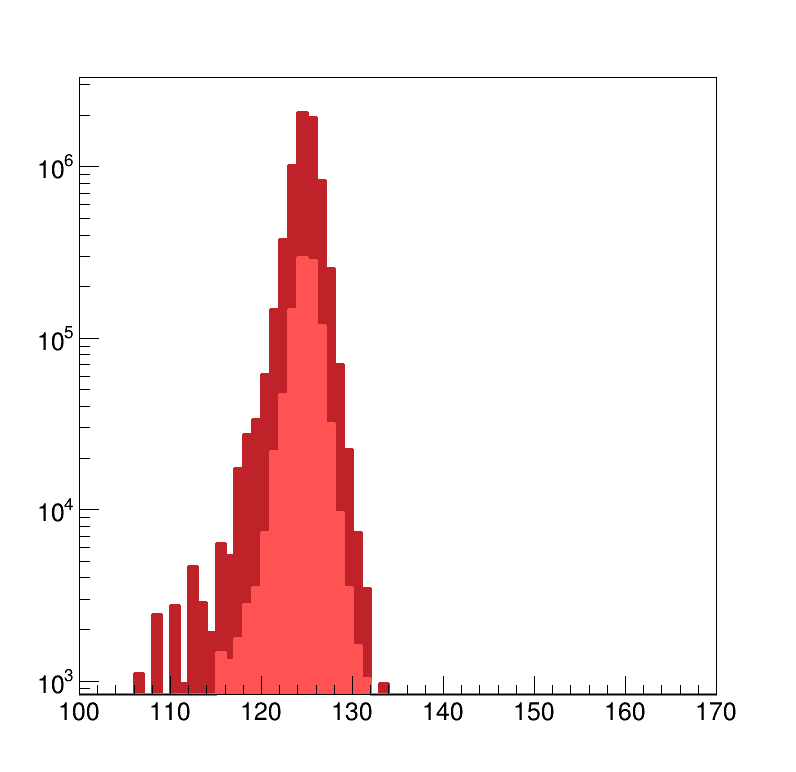

In [3]:
import ROOT
import os
import math

ROOT.gStyle.SetOptStat(0)
#ROOT.gROOT.SetBatch()

year = '2018'
histoName='HCandMass_'
redDark = (191, 34, 41)
redLight = (255,82,82)
orange = (255, 204, 153)

inFileName = "DASKlogs/histoOUTname.root"
inFile = ROOT.TFile.Open(inFileName ,"READ")
h1 = inFile.Get(histoName+year+"_1017")
h2 = inFile.Get(histoName+year+"_1010")
h3 = inFile.Get(histoName+year+"_10")
h4 = inFile.Get(histoName+year+"_11")
h5 = inFile.Get(histoName+year+"_12")
h6 = inFile.Get(histoName+year+"_13")
h7 = inFile.Get(histoName+year+"_14")

h8 = inFile.Get(histoName+year+"_-62")
h9 = inFile.Get(histoName+year+"_-63")
h10 = inFile.Get(histoName+year+"_-64")

if h3: hGjets = h3.Clone()
if h3: hGjets.Add(h4)
if h3: hGjets.Add(h5)
if h3: hGjets.Add(h6)
if h3: hGjets.Add(h7)

'''
if h8: hData = h8.Clone()
if h9: hData.Add(h9)
if h10: hData.Add(h10)
if hData: hData.SetMarkerStyle(20)
if hData: hData.SetMarkerSize(1.2)
if hData: hData.SetMarkerColor(ROOT.kBlack)
if hData: hData.SetLineColor(ROOT.kBlack)
if hData: hData.SetLineWidth(2)
'''

#for h, color in zip([h1,h2,hGjets],[redDark,redLight,orange]):
for h, color in zip([h1,h2],[redDark,redLight]):
    if h:
        h.Scale(38)
        h.SetLineWidth(3)
        h.SetLineColor(ROOT.TColor.GetColor(*color))
        h.SetFillColor(ROOT.TColor.GetColor(*color))

stack = ROOT.THStack("stack","")
#for h in [hGjets,h2,h1]:
for h in [h2,h1]:    
    stack.Add(h)

canv = ROOT.TCanvas("stackcanvas","Stack canvas",800,800)
canv.SetLogy(1)
stack.Draw("HIST")
#hData.Draw("p e same")

canv.Draw()
